# *Suspicious Web Threat Interactions*

- **Overview:**



### Data Preprocessing

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#loading data 
data=pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [2]:
def discovering_data(df):
    print(f'Number of variables: {df.shape[1]}')
    print(f'Number of observations: {df.shape[0]}')
    print(f'Number of duplicates: {df.duplicated().sum()}')
    print(f'Missing cells: {df.isnull().sum().sum()}')
    print(f'Numeric values: {len(df.select_dtypes(include=np.number).columns)}')
    print(f'Categorical values: {len(df.select_dtypes(include="O").columns)}')
    
discovering_data(data)

Number of variables: 16
Number of observations: 282
Number of duplicates: 0
Missing cells: 0
Numeric values: 4
Categorical values: 12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [4]:
data.describe(include='O').T

,count,unique,top,freq
creation_time,282,30,2024-04-26T09:00:00Z,17
end_time,282,30,2024-04-26T09:10:00Z,17
src_ip,282,28,165.225.209.4,29
src_ip_country_code,282,7,US,113
protocol,282,1,HTTPS,282
dst_ip,282,1,10.138.69.97,282
rule_names,282,1,Suspicious Web Traffic,282
observation_name,282,1,Adversary Infrastructure Interaction,282
source.meta,282,1,AWS_VPC_Flow,282
source.name,282,1,prod_webserver,282


- Dropping constant columns like protocol, dst_ip, rule_names, observation_name, source. meta, source.name, and detection_types is the best approach because they don’t contribute to differentiating data points.

In [5]:
data=data.drop(columns=['protocol','dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name','detection_types'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   response.code        282 non-null    int64 
 7   dst_port             282 non-null    int64 
 8   time                 282 non-null    object
dtypes: int64(4), object(5)
memory usage: 20.0+ KB


In [7]:
from sklearn.preprocessing import LabelEncoder
# Convert creation_time and end_time to datetime
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Calculate session duration (in seconds) by subtracting creation_time from end_time
data['session_duration'] = (data['end_time'] - data['creation_time']).dt.total_seconds()

# Handle missing values (if any)
data = data.fillna(0)

# Convert the 'time' column to datetime if it's an object type
data['time'] = pd.to_datetime(data['time'])

### *Feature Engineering*
- Next, we need to engineer the features that will help detect the behaviors you are interested in:
  - Suspicious IP Behavior (high volume of data sent, multiple failed requests):

In [8]:
# Group data by src_ip and calculate the sum of bytes_in, bytes_out, and the count of error responses (e.g., 404, 403)
ip_behavior = data.groupby('src_ip').agg(
    total_bytes_in=('bytes_in', 'sum'),
    total_bytes_out=('bytes_out', 'sum'),
    failed_requests=('response.code', lambda x: sum(x.isin([403, 404]))),
    request_count=('src_ip', 'count')
).reset_index()

# Flag IPs with high bytes_out or multiple failed requests
ip_behavior['suspicious_ip'] = np.where(
    (ip_behavior['total_bytes_out'] > ip_behavior['total_bytes_out'].quantile(0.95)) |
    (ip_behavior['failed_requests'] > ip_behavior['failed_requests'].quantile(0.95)),
    1, 0
)

# Merge the suspicious IP flag back into the main dataset
data = data.merge(ip_behavior[['src_ip', 'suspicious_ip']], on='src_ip', how='left')

In [9]:
data

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,response.code,dst_port,time,session_duration,suspicious_ip
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,200,443,2024-04-25 23:00:00+00:00,600.0,0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,200,443,2024-04-25 23:00:00+00:00,600.0,0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,200,443,2024-04-25 23:00:00+00:00,600.0,0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,200,443,2024-04-25 23:00:00+00:00,600.0,0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,200,443,2024-04-25 23:00:00+00:00,600.0,0
...,...,...,...,...,...,...,...,...,...,...,...
277,41336,13180,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,136.226.77.103,CA,200,443,2024-04-26 09:50:00+00:00,600.0,0
278,3638,3190,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,165.225.26.101,DE,200,443,2024-04-26 09:50:00+00:00,600.0,0
279,25207794,1561220,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,155.91.45.242,US,200,443,2024-04-26 09:50:00+00:00,600.0,1
280,5736,12114,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,165.225.209.4,CA,200,443,2024-04-26 09:50:00+00:00,600.0,0


In [10]:
#Geo-based Threat Detection (unexpected countries or known malicious countries) :
# Aggregate data by country to calculate total bytes out, failed requests, and request count
country_behavior = data.groupby('src_ip_country_code').agg(
    total_bytes_in=('bytes_in', 'sum'),
    total_bytes_out=('bytes_out', 'sum'),
    failed_requests=('response.code', lambda x: sum(x.isin([403, 404]))),  # 403 and 404 as failed requests
    request_count=('src_ip', 'count')
).reset_index()

# Inspect the country behavior data
print(country_behavior.head())

  src_ip_country_code  total_bytes_in  total_bytes_out  failed_requests  \
0                  AE          124400           150066                0   
1                  AT          143512           234970                0   
2                  CA         1562640          1094258                0   
3                  DE          283040           436040                0   
4                  IL           62116           129572                0   

   request_count  
0             16  
1             21  
2             72  
3             28  
4             14  


In [11]:
#Flag countries with high traffic or failed requests:
# Calculate thresholds for suspicious behavior
high_traffic_threshold = country_behavior['total_bytes_out'].quantile(0.95)  # top 5% for outgoing traffic
high_failed_requests_threshold = country_behavior['failed_requests'].quantile(0.95)  # top 5% for failed requests

# Flag countries with high levels of traffic or failed requests
country_behavior['suspicious_country'] = np.where(
    (country_behavior['total_bytes_out'] > high_traffic_threshold) | 
    (country_behavior['failed_requests'] > high_failed_requests_threshold),
    1, 0
)

# Inspect the flagged countries
country_behavior[country_behavior['suspicious_country'] == 1]

,src_ip_country_code,total_bytes_in,total_bytes_out,failed_requests,request_count,suspicious_country
6,US,316412714,21078068,0,113,1


In [12]:
# Merge the suspicious country flag back into the main dataset
data = data.merge(country_behavior[['src_ip_country_code', 'suspicious_country']], 
                  on='src_ip_country_code', 
                  how='left')

# Inspect the updated dataset
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,response.code,dst_port,time,session_duration,suspicious_ip,suspicious_country
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,200,443,2024-04-25 23:00:00+00:00,600.0,0,0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,200,443,2024-04-25 23:00:00+00:00,600.0,0,1
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,200,443,2024-04-25 23:00:00+00:00,600.0,0,0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,200,443,2024-04-25 23:00:00+00:00,600.0,0,1
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,200,443,2024-04-25 23:00:00+00:00,600.0,0,0


In [13]:
#Exfiltration Detection (high bytes_out, low bytes_in, especially on common ports like 80, 443):

# Flag for high bytes_out compared to bytes_in
data['exfiltration_suspicious'] = np.where(
    (data['bytes_out'] > data['bytes_in']) & 
    (data['dst_port'].isin([80, 443])) &
    (data['bytes_out'] > data['bytes_out'].quantile(0.95)),
    1, 0
)

In [14]:
#Brute-Force or DoS Detection (many requests in a short period, high number of 403 errors):

# Count requests per IP and time period (e.g., hourly)
data['hour'] = data['creation_time'].dt.hour
ip_hourly_request_counts = data.groupby(['src_ip', 'hour']).size().reset_index(name='requests_per_hour')

# Flag IPs with unusually high request counts per hour, especially if resulting in 403 errors
data = data.merge(ip_hourly_request_counts, on=['src_ip', 'hour'], how='left')
data['brute_force_or_dos'] = np.where(
    (data['requests_per_hour'] > data['requests_per_hour'].quantile(0.95)) & 
    (data['response.code'] == 403),
    1, 0
)

In [15]:
# Example of aggregating these features by IP or by some other group (e.g., by src_ip)
data['total_bytes_in'] = data.groupby('src_ip')['bytes_in'].transform('sum')
data['total_bytes_out'] = data.groupby('src_ip')['bytes_out'].transform('sum')
data['failed_requests'] = data.groupby('src_ip')['response.code'].transform(lambda x: sum(x.isin([403, 404])))
data['request_count'] = data.groupby('src_ip')['src_ip'].transform('count')

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Select relevant features for modeling
features = ['total_bytes_in', 'total_bytes_out', 'failed_requests', 'request_count', 'suspicious_country', 
            'exfiltration_suspicious', 'requests_per_hour', 'brute_force_or_dos']

# Add a target column (for example, 'suspicious_activity')
data['suspicious_activity'] = data['suspicious_ip'] | data['suspicious_country'] | data['exfiltration_suspicious'] | data['brute_force_or_dos']

# Train-test split
X = data[features]
y = data['suspicious_activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy:  1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        26

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Confusion Matrix:
 [[31  0]
 [ 0 26]]


In [17]:
from sklearn.metrics import accuracy_score

# Train on the full training set
model.fit(X_train, y_train)

# Evaluate on the training set
train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)

# Evaluate on the test set (already done)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 1.0000
Test Accuracy: 1.0000


In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize Stratified KFold (n_splits=5 for example)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation using accuracy
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"Cross-validation Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of Cross-validation Accuracy: {cv_scores.std():.4f}")


Cross-validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-validation Accuracy: 1.0000
Standard Deviation of Cross-validation Accuracy: 0.0000


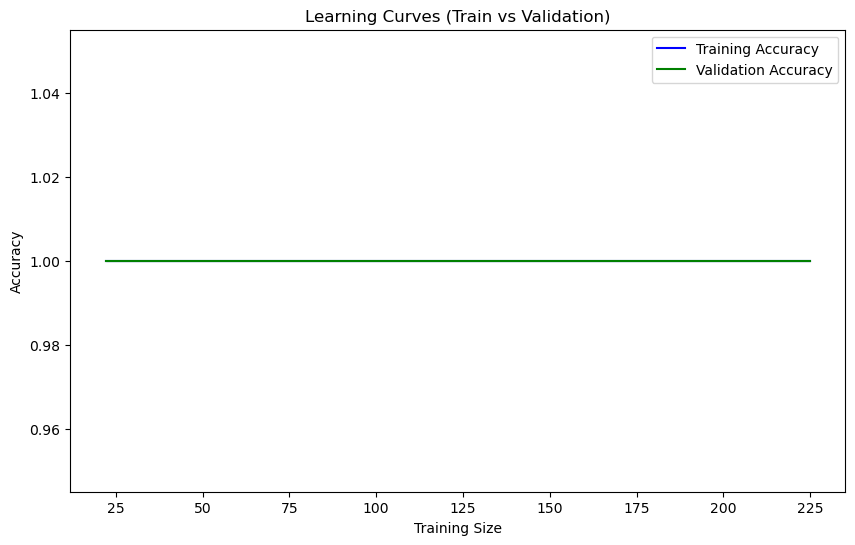

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Get learning curves
train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=kf, n_jobs=-1,
                                                        train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Calculate mean and standard deviation for plotting
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='green')

# Plot confidence intervals
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title("Learning Curves (Train vs Validation)")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [20]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)

In [21]:
# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy:  1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        26

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Confusion Matrix:
 [[31  0]
 [ 0 26]]


In [27]:
import xgboost as xgb
# Initialize XGBoost Classifier
model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
# Fit the model
model.fit(X_train, y_train)
# Predictions
y_pred = model.predict(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        26

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Confusion Matrix:
 [[31  0]
 [ 0 26]]


In [28]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')

print(f"Cross-validation Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of Cross-validation Accuracy: {cv_scores.std():.4f}")


Cross-validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-validation Accuracy: 1.0000
Standard Deviation of Cross-validation Accuracy: 0.0000


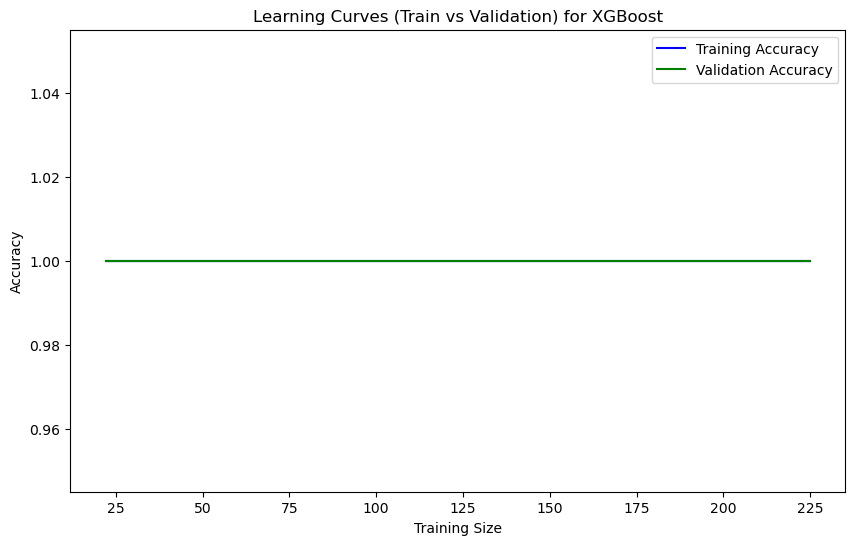

In [29]:
# Calculate mean and standard deviation for plotting
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='green')

# Plot confidence intervals
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title("Learning Curves (Train vs Validation) for XGBoost")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, random_state=42, cv=3, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Use the best model
best_model = random_search.best_estimator_


Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [31]:
# Save the trained XGBoost model
model.save_model('xgboost_model.json')
